# Python for finance and optimization
***

## Assesment II: Option pricing
Paul Lefebvre & Adonis Haouili

In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.rcParams['figure.figsize'] = [12, 6]

Wall time: 2.3 s


# Black-Scholes and Monte-Carlo

We consider a classical Black and Scholes model :

$$\begin{equation} dS_t = \mu S_tdt + \sigma S_tdW_t \end{equation}$$

and recall that the pricing PDE associated with a European payoff $g(ST)$ is:

$$\begin{equation} \frac{\partial P}{\partial t}(S, t) + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 P}{\partial S^2}(S, t) + rS \frac{\partial P}{\partial S}(S, t) - rP(S, t) = 0,  \quad\quad  P(T,S) = g(S) \tag{2}\end{equation}$$ 

In [2]:
def BS_formula(S_0, K, r, sigma, T, option):
    d_1 = (np.log(S_0/K) + (r + sigma**2/2) *T) / (sigma * np.sqrt(T))
    d_2 = d_1 - sigma * np.sqrt(T)
    if option == 'call':
        return S_0 * norm.cdf(d_1) - K * np.exp(-r*T) * norm.cdf(d_2)
    elif option == 'put':
        return K * np.exp(-r*T) * norm.cdf(-d_2) - S_0 * norm.cdf(-d_1)
    else:
        return 'unknown type, either call or put'

def MC(S_0, K, r, sigma, T, option, nb_simulations = 10000000):
    X = np.random.normal(np.log(S_0) + (r - 0.5*sigma**2)*T, sigma * np.sqrt(T), size=nb_simulations)
    if option == 'call':
        g = lambda S : np.maximum(S-K, 0.)
    elif option == 'put':
        g = lambda S : np.maximum(K-S, 0.)
    else:
        return 'unknown type, either call or put'
    return np.mean(np.exp(-r*T) * g(np.exp(X)))

# The implicit scheme
***
## 1. European Call option
---
### <strong> Initial Conditions </strong>
We consider European options, call option $C(S,t)$ of a stock and we are at the expiry time: $t=T$.

- If the current price of the stock $S$ > exercise price $K$, the profit earned from the option is $S-K$.
- If the current price of the stock $S$ < exercise price $K$, then no need to exercise the call option, this option payoff and value is zero.

Thus, for a call option :
$$C(S,T) = max(S-K,0) \tag{3}$$

This is the final condition, but we will have to deal with an inital condition with a form of $C(S,0) = g(S)$ as stated in equation (2). Thus, by a change of variables $ t^*(t) = T - t$, we obtain :

$$\frac{\partial V(S,t)}{\partial t} = - \frac{\partial V(S,t^*)}{\partial t^*}$$

- substituting in the Black-Scholes equation (2), we obtain:

$$-\frac{\partial V}{\partial t^*}(S, t^*) + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}(S, t^*) + rS \frac{\partial V}{\partial S}(S, t^*) - rV(S, t^*) = 0 $$

- changing the sign, and use $C$ instead of $V$ since it is a call option:

$$\frac{\partial C}{\partial t^*}(S, t^*) - \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 C}{\partial S^2}(S, t^*) - rS \frac{\partial C}{\partial S}(S, t^*) + rC(S, t^*) = 0 \tag{4}$$


### <strong> Boundary Conditions</strong>

In order to make it a well-posed partial differential equation, <strong>we have to define the boundary conditions on both sides</strong>. The current price of the stock $S$ can take value in the interval $[0,\infty)$, which is unbounded.

$$\begin{cases} \textrm{left boundary: }S=0\textrm{, then }C(0,t^*) = 0\\
\textrm{right boundary: }S\rightarrow \infty\textrm{, then }C(S,t^*) = (S-E)\\ \end{cases}$$


Here, <strong>since we want a limited grid space, which we name $p$, we need to set an artificial bound $S_{max}$ concerning the space discretization</strong>. We think that this limit depends on time to maturity $T$ and volatility ($\sigma$), the higher both variables, the high the artifical bound. The grid space limitations are set via the variable H, we then have : 

$$S_{max} = S + H $$

thus, including actualiazation, the boundary conditions can be written as follows:

$$\begin{cases} p[0,:] = 0\\ p[-1,:] = e^{(log(S)+H)} - Ke^{(-r*ts)}\\ \end{cases}$$

<strong> Recap: </strong>

| Boundaries    .| Program | Value |
|---|---|---|
| $C ( S , T )$|p[:,0] |S: np.maximum(S-K, 0.) |
| $C ( 0 , t^* )$|p[0,:] |0 |
| $C(S_{max},t^*)$|p[-1,:] | $e^{(log(S)+H)} - Ke^{(-r*ts)}$|

<br><br>

***
## 2. European Put option
***
### <strong> Initial Conditions </strong>

Thus, for a put option :
$$P(S,T) = max(K-S,0) \tag{3 bis}$$

Equation (4) identical.

### <strong> Boundary Conditions</strong>

A put option has a payoff limited to K (when the stock value reach 0), and 0 when the stock trades above the strike.

$$\begin{cases} \textrm{left boundary: }S=0\textrm{, then }P(0,t^*) = K-S = K\\
\textrm{right boundary: }S\rightarrow \infty\textrm{, then }P(S,t^*) = 0\\ \end{cases}$$


Concerning the space discretization, the bound is set when the max payoff is reached :

$$S_{min} = S - H $$

thus, including actualiazation, the boundary conditions can be written as follows:

$$\begin{cases} p[0,:] = Ke^{(-r*ts)} - e^{(log(S)-H)} \\ p[-1,:] = 0\\ \end{cases}$$

<strong> Recap: </strong>

|boundaries   .| Program | Value|
|-----------|---------|------|
|$P(S,T)$ |p[:,0]|S: np.maximum(K-S, 0.)|
|$P(0,t^*)$   |p[0,:]   |$Ke^{(-r*ts)} - e^{(log(S)-H)}$    |
|$P(S_{min},t^*)$|p[-1,:] | 0|

***

In [3]:
##
#an explanation of the differences between the call and put methods can be found below this cell.
##

def pde_scheme_implicit(S_0, r, sigma, T, K, H, nb_x_side, nb_t, option, name):
    nb_x = 2 * nb_x_side + 1
    xs = np.linspace(np.log(S_0) - H, np.log(S_0) + H, nb_x)
    dx = 2. * H / (nb_x - 1.)
    dt = T / (nb_t - 1.)
    ts = np.linspace(0., T, nb_t)
    p = np.empty([nb_x, nb_t])

    if option == 'call':
        g = lambda S: np.maximum(S-K, 0.)
    elif option == 'put':
        g = lambda S: np.maximum(K-S, 0.)
    else:
        print('unknown type, either call or put')
        return np.nan, np.nan
    
    p[:,0] = g(np.exp(xs))

    if option == 'call':
        p[0,:] = 0
        p[-1,:] = np.exp(np.log(S_0)+H) - K * np.exp(-r*ts)

    elif option == 'put':
        p[0,:] = K * np.exp(-r*ts) - np.exp(np.log(S_0)-H)
        p[-1,:] = 0

    d = 1. + dt*(r+(r-0.5*sigma**2)/ dx + sigma**2 /dx**2)
    sup_d = -dt*((r-0.5*sigma**2)/dx+0.5*sigma**2/dx**2) 
    inf_d = -dt*(0.5 * sigma**2 / dx**2)

    A = np.zeros([nb_x-2, nb_x])
    A = np.diag(d * np.ones(nb_x-2)) + np.diag(sup_d * np.ones(nb_x-3), 1) + np.diag(inf_d * np.ones(nb_x-3), -1)
    invA = np.linalg.inv(A)
    
    if option == 'call':
        v = np.zeros_like(p[1:-1,0])
        v[-1] = 1.
        for t in range(1, nb_t,1):
            p[1:-1,t] = invA @ (p[1:-1,t-1]  - sup_d * p[-1,t] * v)

    elif option == 'put':
        v = np.zeros_like(p[0:-2,0])
        v[0] = 1.
        for t in range(1, nb_t,1):
            p[0:-2,t] = invA @ (p[0:-2,t-1]  - sup_d * p[0,t] * v)

    t, x = np.meshgrid(ts,np.exp(xs))
    ax= plt.axes(projection='3d')
    ax.plot_surface(t,x,p)
    ax.set_title('surface of the ' + name)
    plt.show()
    
    plt.plot(np.exp(xs),p[:,-1])
    plt.title(name + " pricing as of today")
    plt.show()
    plt.plot(np.exp(xs),p[:,0])
    plt.title(name + " expected payoff at maturity")
    plt.show()

    return p, p[nb_x_side, -1]


***
## Difference between the call and put methods

g : from the equation 3 and 3 bis. 

p[0,:] and p[-1,:] : from both recap 

The remaining changes are implemented to adapt the behavior of the system to the boundaries of the option:
- if call: the array 'v' should have '1' <strong>at the last element</strong> to encapsulate the boundary p[-1,:] and the system is filled at each 'dt' <strong>from the second element</strong> (as the first =0) <strong>up to the last one</strong>.
- if put: the array 'v' should have '1' <strong>at the first element</strong> to encapsulate the boundary p[0,:] and the system is filled at each 'dt' <strong>from the first element up to the one before the last one</strong> (as the last one is 0).


***
## The call spread:
Assuming $S_0=10$, $\sigma=25\%$, $r=2\%$:
1. Long leg: ATM 3y call: $K=10$, $T=3$
2. Short leg: ITM (150%) 3y call: $K=S_0/150\%$, $T=3$

Based on Dura's ("Numerical approximation of Black-Scholes equation." Annals of the Alexandru Ioan Cuza University-Mathematics 56.1 (2010): 39-64), it is recommended to set $S_{max}$ to four times the strike. 
Given the quite important volatility, and the time to maturity (especially in the put) we set H to: 

$$ H = log\left(S*T*(1+\sigma)\right) - log(S)$$ 

***



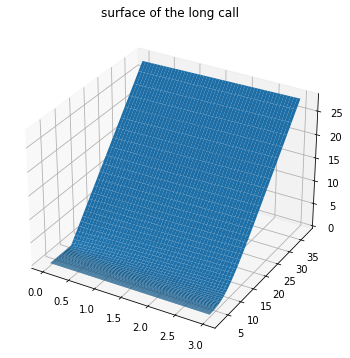

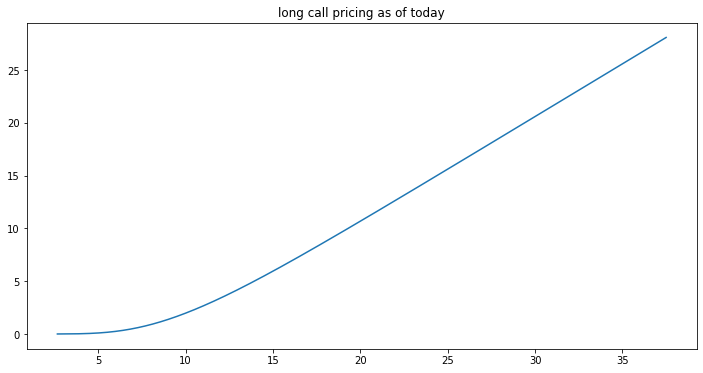

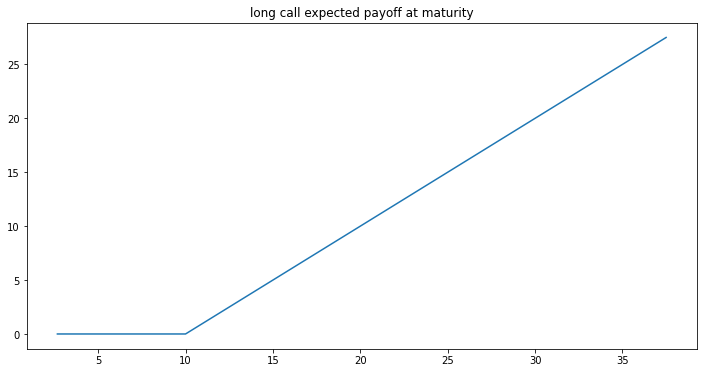

long call implicit scheme price is 1.970
long call BS price is 1.971
long call MC price is 1.971
Wall time: 3.95 s


In [4]:
%%time
#pricing of the long call

S = 10.
r = 0.02
sigma = 0.25

T = 3.
K = S

H = np.log(S*T*(1+sigma)) - np.log(S)
nb_x_side = 1000
nb_t = 1000

long_call_table, long_call = pde_scheme_implicit(S, r, sigma, T, K, H, nb_x_side, nb_t, option='call',name= "long call")
print(f'long call implicit scheme price is {long_call:.3f}')

long_call_BS = BS_formula(S, K, r, sigma, T,option='call')
print(f'long call BS price is {long_call_BS:.3f}')

long_call_MC = MC(S, K, r, sigma, T, option='call')
print(f'long call MC price is {long_call_MC:.3f}')

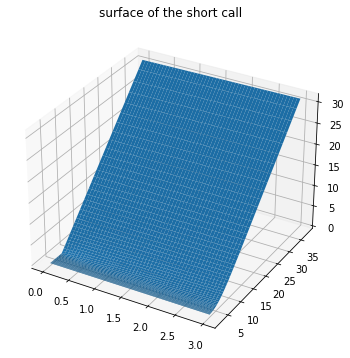

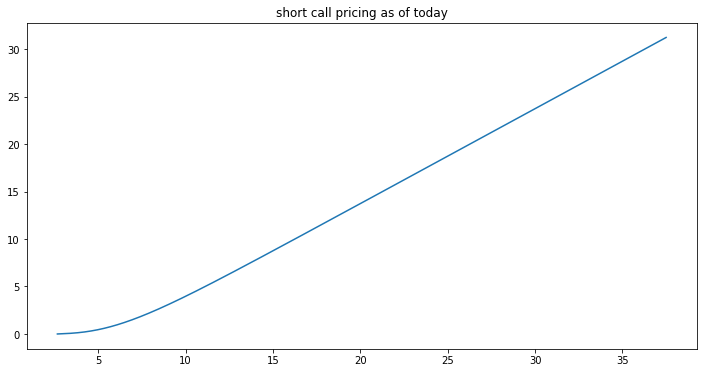

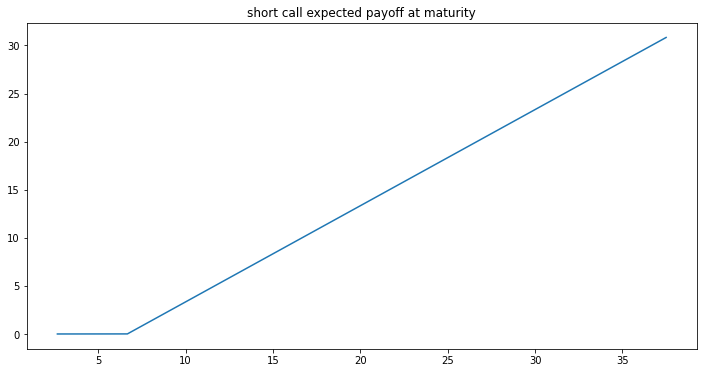

Short call implicit scheme price is 3.965
Short call BS price is 3.965
Short call_MC price is 3.968
Wall time: 3.78 s


In [5]:
%%time
#pricing of the short call

K = S/1.5

H = np.log(S*T*(1+sigma)) - np.log(S)
nb_x_side = 1000
nb_t = 1000

short_call_table, short_call = pde_scheme_implicit(S, r, sigma, T, K, H, nb_x_side, nb_t, option='call', name ="short call")
print(f'Short call implicit scheme price is {short_call:.3f}')

short_call_BS = BS_formula(S, K, r, sigma, T,option='call')
print(f'Short call BS price is {short_call_BS:.3f}')

short_call_MC = MC(S, K, r, sigma, T, option='call')
print(f'Short call_MC price is {short_call_MC:.3f}')

In [6]:
call_spread = long_call - short_call
print(f' Call spread price from implicit is {call_spread:.3f},', '\n',
f'Call spread price from BS is {long_call_BS-short_call_BS:.3f}', '\n',
f'Call spread price from MC is {long_call_MC-short_call_MC:.3f}')

print('\n','As expected, a call spread with a short leg deeper in the money than the long leg results in negative price, as we sell a more valuable option than the one we are buying.')

 Call spread price from implicit is -1.994, 
 Call spread price from BS is -1.994 
 Call spread price from MC is -1.996

 As expected, a call spread with a short leg deeper in the money than the long leg results in negative price, as we sell a more valuable option than the one we are buying.


***
## The put:
Assuming $S_0=10$, $\sigma=25\%$, $r=2\%$:
- Long put: OTM (80%) 3y call: $K=S_0*80\%$, $T=10$


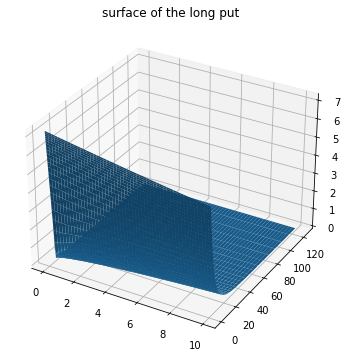

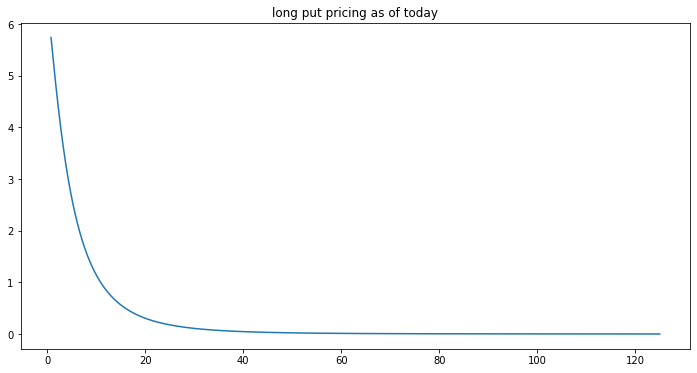

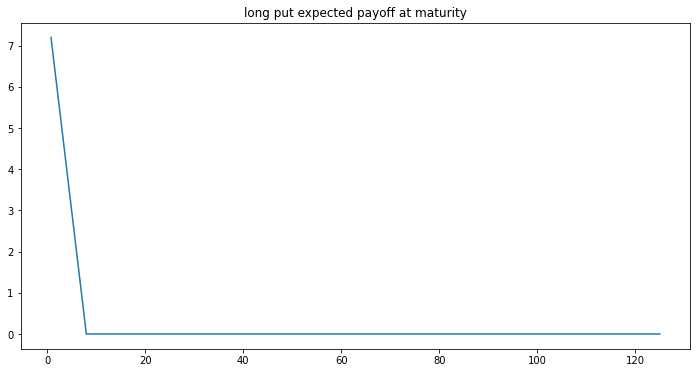

put implicit scheme price is 1.149
put BS price is 1.150
put_MC price is 1.150
Wall time: 3.85 s


In [7]:
%%time
#pricing of the put

T = 10
K = S*.8

H = np.log(S*T*(1+sigma)) - np.log(S)
nb_x_side = 1000
nb_t = 1000

put_table, put = pde_scheme_implicit(S, r, sigma, T, K, H, nb_x_side, nb_t, option='put', name='long put')
print(f'put implicit scheme price is {put:.3f}')

put_BS = BS_formula(S, K, r, sigma, T,option='put')
print(f'put BS price is {put_BS:.3f}')

put_MC = MC(S, K, r, sigma, T, option='put')
print(f'put_MC price is {put_MC:.3f}')